<a href="https://colab.research.google.com/github/KauaHenSilva/python_predict_stock_prices/blob/main/main_mult_prov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recuperação por download

In [40]:
# @markdown #### Caso escolheu o tipo de recuperação drive/ambos e não tenha os arquivos, faça um atalho desse drive:
link_do_drive = "https://drive.google.com/drive/folders/1uwHnZRnVPt6ha5s_cyZSAoCP7ATWBEwN?usp=drive_link" #@param {type:"string"}
path_atalho_drive = "/content/drive/MyDrive/Projetos Do GitHub/python_predict_stock_prices" #@param {type:"string"}
path_download = "python_predict_stock_prices" #@param {type:"string"}

In [41]:
import os
import zipfile

if os.path.exists('python_download_file_drive'):
  !cd python_download_file_drive && git pull
else:
  !git clone https://github.com/KauaHenSilva/python_download_file_drive
%pip install --upgrade --quiet -r python_download_file_drive/requirements.txt


Already up to date.


In [42]:
try:
    from google.colab import drive
    from google.colab import auth
    from googleapiclient.discovery import build
    auth.authenticate_user()

    !python "python_download_file_drive/main.py" {link_do_drive} {path_download} # ALERTA: Caso o drive bote limite de download comente essa linha

    drive.mount('/content/drive')
    if not os.path.exists(path_atalho_drive):
      print("[INFO] Atalho no drive não encontrado.")

except:

    if os.path.exists(f"{path_download}.zip"):
      print(f"Descompactando {path_download}.zip")
      !rm -rf {path_download}
      with zipfile.ZipFile(f"{path_download}.zip", 'r') as zip_ref:
        zip_ref.extractall(f"{path_download}_temp")
        !mv {path_download}_temp/* {path_download}
        !rm -rf {path_download}_temp
        !rm -rf {path_download}.zip

    if not os.path.exists(path_download):
      raise Exception(f"Você não está nos altenticado nos servidores do google colab. Para prosseguir, faça o download dos arquivos que estão presente no drive e tente novamente. O link do drive {link_do_drive}. A pasta deve está dentro de /content/")


In [43]:
def get_referencia_valida(path, file_init):
    path_download = os.path.join(f"/content/{file_init}", path)
    path_drive = os.path.join(path_atalho_drive, path)

    bool_download = os.path.exists(path_download)
    bool_drive = os.path.exists(path_drive)

    if not bool_download and not bool_drive:
        raise Exception(f"Arquivo não encontrado em nenhum dos caminhos (Download ou Drive). Caminhos: {path_download}, {path_drive}")

    if not bool_drive and bool_download:
        print("[INFO] Arquivo encontrado no download, mas não no drive.")
        return path_download

    if bool_drive and not bool_download:
        print("[INFO] Arquivo encontrado no drive, mas não no download.")
        return path_drive

    return path_download


# Bolsa de valores

In [44]:
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

In [45]:
np.__version__, pd.__version__, matplotlib.__version__, tf.__version__, sklearn.__version__

('1.26.4', '2.2.2', '3.8.0', '2.16.1', '1.6.0')

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import  MinMaxScaler
import matplotlib.pyplot as plt

In [47]:
path_database_test = get_referencia_valida("petr4_teste.csv", path_download)
path_database_treinamento = get_referencia_valida("petr4_treinamento.csv", path_download)

[INFO] Arquivo encontrado no download, mas não no drive.
[INFO] Arquivo encontrado no download, mas não no drive.


In [48]:
database_treinamento = pd.read_csv(path_database_treinamento)
database_treinamento = database_treinamento.dropna()
base_treinamento = database_treinamento.iloc[:, 1:7].values

In [49]:
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [50]:
x = np.array([base_treinamento_normalizada[i-90:i, 0:6] for i in range(90, len(base_treinamento_normalizada))])
y = np.array([base_treinamento_normalizada[i, 0] for i in range(90, len(base_treinamento_normalizada))])
x.shape, y.shape

((1152, 90, 6), (1152,))

In [51]:
net = Sequential()

net.add(LSTM(units=100, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
net.add(Dropout(0.3))

net.add(LSTM(units=50, return_sequences=True))
net.add(Dropout(0.3))

net.add(LSTM(units=50, return_sequences=True))
net.add(Dropout(0.3))

net.add(LSTM(units=50))
net.add(Dropout(0.3))

net.add(Dense(units=1, activation='linear'))

net.summary();

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 90, 100)             │          42,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 90, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 90, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 90, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,451 (443.17 KB)

 Trainable params: 113,451 (443.17 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
net.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [116]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=True)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=True)
mcp = ModelCheckpoint(filepath='pesos.keras', monitor='loss', save_best_only=True, verbose=True)

In [117]:
net.fit(x, y, epochs=100, batch_size=32, callbacks=[es, rlr, mcp]);

Epoch 1/100
 1/36 ━━━━━━━━━━━━━━━━━━━━ 4:59 9s/step - loss: 0.0048 - mean_absolute_error: 0.0529
Epoch 1: loss improved from inf to 0.01002, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s -163016us/step - loss: 0.0114 - mean_absolute_error: 0.0766 - learning_rate: 0.0010
Epoch 2/100
35/36 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0072 - mean_absolute_error: 0.0639
Epoch 2: loss improved from 0.01002 to 0.00781, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0073 - mean_absolute_error: 0.0640 - learning_rate: 0.0010
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0074 - mean_absolute_error: 0.0660
Epoch 3: loss improved from 0.00781 to 0.00702, saving model to pesos.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0074 - mean_absolute_error: 0.0659 - learning_rate: 0.0010
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0061 - mean_absolute_error: 0.0596
Epoch 4: loss improved from 0.00702 to 0.00667, saving m

In [118]:
database_test = pd.read_csv(path_database_test)

In [119]:
y_teste = database_test.iloc[:, 1:2].values

In [120]:
frames = [database_treinamento, database_test]

In [121]:
base_completa = pd.concat(frames)
base_completa = base_completa.drop('Date', axis = 1)

In [122]:
entradas = base_completa[len(base_completa) - len(database_test) - 90:].values
entradas = normalizador.transform(entradas)

In [123]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0:6])
X_teste = np.array(X_teste)

In [124]:
previsoes = net.predict(X_teste)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


In [125]:
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [126]:
previsoes = normalizador_previsao.inverse_transform(previsoes)

In [127]:
previsoes.mean()

17.379026

In [128]:
y_teste.mean()

17.87454563636364

In [129]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_teste, previsoes)

0.4979570029629794

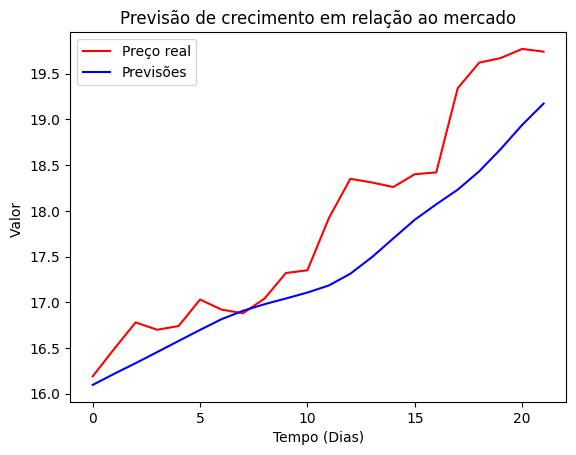

In [134]:
plt.plot(y_teste, color = "red", label = "Preço real")
plt.plot(previsoes, color = "blue", label = "Previsões")
plt.title("Previsão de crecimento em relação ao mercado")
plt.xlabel("Tempo (Dias)")
plt.ylabel("Valor ")
plt.legend();